In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import datetime
import pickle

from copy import copy
from itertools import count
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
from PIL import Image

# %matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

%load_ext autoreload
%autoreload 2


In [0]:
!pip install wandb

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
import wandb


Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
class Preprocess(gym.ObservationWrapper):
    def __init__(self, env):
        """Apply preprocessing steps as defined in original DeepMind Atari paper:
        https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
        """
        super(Preprocess,self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0.0, high=255, shape=(84,84,1), dtype=env.observation_space.dtype)

    def observation(self, obs):
        new_obs = obs.transpose((2, 0, 1))
        new_obs = np.ascontiguousarray(obs, dtype=np.float32) / 255
        new_obs = torch.from_numpy(new_obs)

        preprocess = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((84,84)),          # Resize;            size: (3,84,84)
                                         transforms.Grayscale(),           # Apply greyscale;   size: (1,84,84)
                                         transforms.ToTensor()])           # Make into tensor

        new_obs = preprocess(obs).to(device)
        return new_obs


class MoveImgChannel(gym.ObservationWrapper):
    def __init__(self,env):
        super(MoveImgChannel,self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0.0,high=1.0,
                                              shape=(self.observation_space.shape[-1],
                                                     self.observation_space.shape[0],
                                                     self.observation_space.shape[1]),
                                              dtype=np.float32)
    def observation(self,obs):
        obs = np.moveaxis(obs.cpu().numpy(),2,0)
        return torch.from_numpy(obs)

# Stack previous 4 frames using OpenAI Gym wrapper
# ADAPTED FROM: OpenAI Baselines https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames using deque.
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)      # store previous 4 states in a deque
        self.observation_space = gym.spaces.Box(low=0, high=1.0, shape=(4,84,84), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        frames = np.concatenate([s.cpu() for s in self.frames], axis=0)    # concatenate the first frame 4 times for initial state (no other states seen yet)
        frames = torch.from_numpy(frames).to(device)
        return frames

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        frames = np.concatenate([s.cpu() for s in self.frames], axis=0)
        frames = torch.from_numpy(frames)
        frames = frames.to(device)
        return frames, reward, done, info               # return stack of 4 previous frames instead of just one frame (and other stuff)

# Apply classes for preprocessing and frame stacking to create environment
def make_env(env_name):
    env = gym.make(env_name)
    env = Preprocess(env)
    env = FrameStack(env, 4)
    #env = MoveImgChannel(env)
    return env


Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

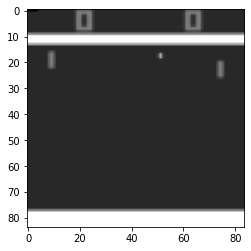

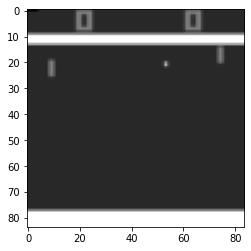

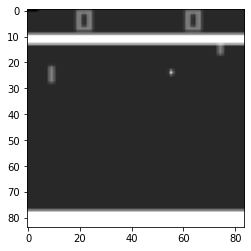

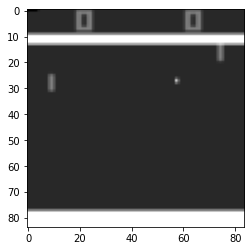

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
# Sample some frames to check preprocessing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env("PongDeterministic-v4")
observation = env.reset()

for i in range(55):
    if i > 50:
        plt.imshow(observation.cpu().squeeze(0).permute(1, 2, 0).numpy()[:,:,1],cmap="gray")  # interpolation='none')
        plt.show()

    observation, _, _, _ = env.step(random.randrange(6))


In [0]:
print("Input shape: ", env.observation_space.shape)
print("Action space size: ", env.action_space.n)
print("Actions: ", env.get_action_meanings())

# Check dimensions of observation are in correct order (batch size, channels (stack of 4 1 channel frames), height, width)
print(observation.shape)

Input shape:  (4, 84, 84)
Action space size:  6
Actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
torch.Size([4, 84, 84])
Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
# Create replay memory object to store a set number of transitions to sample from at each step
Transition = namedtuple(
    'Transition', ['state', 'action', 'reward', 'next_state', 'terminal'])

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory_size = capacity
        self.memory_pos = 0
        self.memory = []

    def save_transition(self, transition):
        # If memory isn't full yet, just append new memory to end
        if len(self.memory) < self.memory_size:
            self.memory_pos = len(self.memory)
            self.memory.append(transition)
        else:
            self.memory_pos = (self.memory_pos + 1) % self.memory_size  # get index of next place to store memory (overwrite oldest first)

            # Add new transition to memory
            self.memory[self.memory_pos] = transition

    def sample(self, batch_size):
        mem_size = len(self.memory)

        # Take a random sample of size batch_size from memory (without replacement)
        batch_indices = np.random.choice(mem_size, batch_size, replace=False)
        batch = [self.memory[idx] for idx in batch_indices]
        return batch

    def __len__(self):
        return len(self.memory)

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
class DQN(nn.Module):
    def __init__(self, input_dims, n_actions=6, learning_rate=0.00025):
        super(DQN, self).__init__()
        self.input_dims = input_dims
        self.actions = n_actions
        self.lr = learning_rate
        # Network from DeepMind paper
        self.conv1 = nn.Conv2d(4, 16, 8, stride=4)  # 4 input channels (4 frames of 1 channel images (greyscale))
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
        #self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        with torch.no_grad():
            dummy = torch.zeros((1, *input_dims))
            x = F.relu(self.conv1(dummy))
            x = F.relu(self.conv2(x))
            #x = F.relu(self.conv3(x))
            s = x.shape
            fc1_size = s[1] * s[2] * s[3]

        self.fc1 = nn.Linear(fc1_size, 256)
        self.fc2 = nn.Linear(256, self.actions)  # 6 possible actions
        self.optimiser = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten before FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Return output, i.e. Q values of actions for input state (vector length 6)
        return x

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
class DQNAgent(object):  # object
    def __init__(self, input_dims, n_actions=6, capacity=250000, lr=0.0001, gamma=0.99, epsilon=1,
                 eps_min=0.1, eps_decay=1e-5, batch_size=32, target_update=1000):
        # Defaults are parameters from DeepMind paper
        # Size of state and action spaces
        self.state_shape = input_dims
        self.n_actions = n_actions
        self.capacity = capacity
        self.actions = [i for i in range(env.action_space.n)]

        # Hyperparameters
        self.learning_rate = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.target_update = target_update  # number of steps before updating the target network weights
        self.step_num = 0  # keep track of steps and eps to know when to update target network
        self.ep_steps = 0
        self.loss = nn.SmoothL1Loss()


Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
class History():
    def __init__(self, plot_size=300, plot_every=5):
        self.plot_size = plot_size
        self.episode_durations = deque([], self.plot_size) # steps per episode
        self.means = deque([], self.plot_size) # moving average steps per ep
        self.episode_loss = deque([], self.plot_size) # average loss per step per ep
        self.indexes = deque([], self.plot_size) # index of last 300 episodes 
        self.step_loss = [] # loss per step
        self.step_eps = []
        self.peak_reward = 0 # peak number of steps per ep?
        self.peak_mean = 0
        self.moving_avg = 0 # moving avg of steps per ep
        self.step_count = 0
        self.total_episode = 0 # total number of eps
        self.plot_every = plot_every

    def update(self, t, episode_loss):
        self.episode_durations.append(t + 1)
        self.episode_loss.append(episode_loss / (t + 1))
        self.indexes.append(self.total_episode)
        if t + 1 > self.peak_reward:
            self.peak_reward = t + 1
        if len(self.episode_durations) >= 100: # after 100 episodes
            self.means.append(sum(list(self.episode_durations)[-100:]) / 100) # mean of last 100 episode durations (steps per ep)
        else: # if fewer than 100 eps:
            self.moving_avg = self.moving_avg + (t - self.moving_avg) / (self.total_episode + 1)
            self.means.append(self.moving_avg)
        if self.means[-1] > self.peak_mean:
            self.peak_mean = self.means[-1] # peak avg steps per ep

        if self.total_episode % self.plot_every == 0:
            self.plot()

    def plot(self):
        display.clear_output(wait=True)

        f, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 6))
        ax1.plot(self.indexes, self.episode_durations) # epsiode x steps per ep
        ax1.plot(self.indexes, self.means) # episode x moving avg steps per ep
        ax1.set_xlabel("episode")
        ax1.axhline(self.peak_reward, color='g') # peak number steps per ep 
        ax1.axhline(self.peak_mean, color='g') # peak moving avg steps per ep

        ax2 = ax1.twinx()
        ax2.plot(self.indexes, self.episode_loss, 'r') # episodes x avg loss per ep

        ax4 = ax3.twinx()
        total_step = len(self.step_loss)
        sample_rate = total_step // self.plot_size if total_step > (
            self.plot_size * 10) else 1
        ax3.set_title('total number of steps: {0}'.format(total_step))
        ax3.plot(self.step_eps[::sample_rate], 'g') # total steps x epsilon per step
        ax4.plot(self.step_loss[::sample_rate], 'b') # total steps x loss per step

        plt.pause(0.00001)

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
def next_action(state, policy_net):
    rd = random.random()
    if rd < agent.epsilon:  # explore
        action = random.randrange(agent.n_actions)
    else:
        # exploit
        with torch.no_grad():
            action = policy_net(state.unsqueeze(0)).max(1)[1].item()
    return action

def train_agent(policy, target, memory):
    # Need at least batch_size transitions stored in memory before sampling from memory
    if len(memory) < agent.batch_size:
        return 0

    # Check if target network weights should be updated this step
    if agent.step_num % agent.target_update == 0:
        target.train()
        target.load_state_dict(policy.state_dict())

    # Sample batch of memories
    transitions = memory.sample(agent.batch_size)
    states = torch.stack(([t.state for t in transitions])).to(device)
    rewards = torch.stack(([t.reward for t in transitions])).to(device)
    next_states = torch.stack(([t.next_state for t in transitions])).to(device)
    actions = torch.stack(([torch.LongTensor([t.action]) for t in transitions])).to(device)
    mask = torch.stack([torch.Tensor([0]) if t.terminal else torch.Tensor([1]) for t in transitions]).to(device)

    with torch.no_grad():
        q_next = target(next_states).max(1)[0].detach() # (32,1)

    policy.optimiser.zero_grad()

    q_current = policy(states) # (32,6)
    actions_onehot = F.one_hot(actions, agent.n_actions).squeeze(1).to(device) # (32,6)
    q_current_acts = torch.sum(q_current * actions_onehot, -1).view(agent.batch_size,1) # (32,1)
    q_targets = torch.zeros((agent.batch_size,1)).to(device) # (32,1)
    q_targets = q_next * mask[:,0]   # non-terminal states take max next Q-value from target model
    q_target = q_targets.view(agent.batch_size,1) * agent.gamma + rewards # (32,1)

    # Perform a single gradient update just for batch in consideration
    policy_net.train()
    loss_fn = agent.loss # Huber loss
    loss = loss_fn(q_current_acts, q_target)
    loss.backward()  # backprop loss
    policy.optimiser.step()  # perform gradient update

    return loss.detach().item()

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f22cea6f1e0> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
# Hyperparameters
batch_size = 32 # 32
learning_rate = 0.0001 # 0.0001
gamma = 0.99
eps_min = 0.02 # 0.05 (best) | try next: 0.02
eps_decay = 0.99999
capacity = 100000 #100000 (best) | try next: 25000
target_update = 2500 #5000 (best) | try next: 1000
num_eps = 400
steps_before_train = 10 # don't start training right from beginning of epoch

# Config for wandb
wandb.init(project="reinforcement-learning-coursework", name="dqn-pong",
           config={"batch size":batch_size, "learning_rate": learning_rate, "eps_min": eps_min,
                   "eps_decay": eps_decay,"capacity": capacity,
                   "target_update": target_update})

env = make_env("PongDeterministic-v4")
observation = env.reset()
input_shape = np.array(observation.shape)
n_actions = env.action_space.n

agent = DQNAgent(input_shape, n_actions, lr=learning_rate, capacity=capacity, gamma=gamma, eps_min=eps_min, eps_decay=eps_decay,
                 batch_size=batch_size, target_update=target_update)  # other params default
policy_net = DQN(input_shape, n_actions, learning_rate).to(device)
target_net = DQN(input_shape, n_actions, learning_rate).to(device)
target_net.load_state_dict(policy_net.state_dict())
memory = ReplayMemory(capacity)
history = History()

In [0]:
# If loading checkpoint:
# resume = False
# model_name = 'Basic_DQN' + '_40_200503-1956'# fill in file path for checkpoint
# save_name = 'checkpoints/' + model_name

# if resume:
#     with open(save_name + '.pickle', 'rb') as f:
#         data = pickle.load(f)
#         history = data['history']
#         agent = data['agent']
#         memory = data['memory']
#     checkpoint = torch.load(save_name + '.pt')
#     policy_net = DQN(input_shape, n_actions, learning_rate).to(device)
#     target_net = DQN(input_shape, n_actions, learning_rate).to(device)
#     policy_net.load_state_dict(checkpoint['policy_net'])
#     target_net.load_state_dict(checkpoint['target_net'])
#     policy_net.optimiser.load_state_dict(checkpoint['optimiser'])


In [0]:
target_net.eval() # so that weights aren't updated
scores, step_eps, avg_losses = [], [], []

for e in range(num_eps):
    score = 0
    avg_loss = 0
    agent.ep_steps = 0
    history.total_episode += 1

    # Take initial state as stack of first frame 4 times
    state = env.reset()

    for t in count():
        agent.step_num += 1
        agent.ep_steps += 1
        history.step_count += 1
        # Take an action (epsilon hyperparameters are defined when creating agent)
        action = next_action(state, policy_net)
        next_state, reward, done, info = env.step(action)
        score += reward

        # Save transition to memory
        reward = torch.tensor([reward], device=device)
        memory.save_transition(Transition(state, action, reward, next_state, done))
        state = next_state

        # Sample batch of memories and update weights
        if agent.ep_steps > steps_before_train:
            loss = train_agent(policy_net, target_net, memory)
            avg_loss += loss
            history.step_loss.append(loss)
            wandb.log({'loss': loss, 'eps': agent.epsilon}, step=agent.step_num)

        history.step_eps.append(agent.epsilon)
        agent.epsilon = agent.eps_decay ** agent.step_num if \
         agent.epsilon > agent.eps_min else agent.eps_min

        if done:
            history.update(t, avg_loss)
            break
        # raise Exception()
    step_eps.append(agent.epsilon)  # save epsilon value of episode
    scores.append(score)
    avg_losses.append(avg_loss / (t + 1))
    avg_score = np.mean(scores[-100:])
    x = [i + 1 for i in range(num_eps)]
    wandb.log({'avg reward': avg_score},step=agent.step_num)
    # plotLearning(x, scores, step_eps)

    print("Episode: ", e + 1, " | Score: %.2f" % score, " | Average score: %.2f" % avg_score,
          " | Episode Loss: %.6f" % avg_losses[-1],
          " | Epsilon: %.4f" % agent.epsilon, " | Steps: %i" % agent.step_num)

    # Store state checkpoints every 40 epochs
    # if e % 40 == 0:
    #     model_name = 'Basic_DQN_' + str(e) + "_" + str(datetime.datetime.now().strftime("%y%m%d-%H%M"))
    #     save_name = '/content/drive/My Drive/Colab Notebooks/checkpoints/' + model_name

    #     torch.save({
    #         'policy_net': policy_net.state_dict(),
    #         'target_net': target_net.state_dict(),
    #         'optimiser': policy_net.optimiser.state_dict()
    #     }, save_name + '.pt')

    #     with open(save_name + '.pickle', 'wb') as f:
    #         pickle.dump({'agent': agent, 'history': history, 'agent': agent},
    #                     f, pickle.HIGHEST_PROTOCOL)


RuntimeError: ignored

An episode in Pong runs until one of the players reaches a score of 21.

Rounds in Pong correspond to one of the players getting a score & reward of 1 and winning a rally, and the losing player getting a score of 0 and a reward of -1.

The running mean score per episode, over the trailing 100 episodes, at the point I stopped training was 2.5, i.e. the trained AI Agent would win each episode 21 points to 18.5. 

In [0]:
save_name_done = 'checkpoints/' + model_name + "_done_" + str(datetime.datetime.now().strftime("%y%m%d-%H%M"))
torch.save({
    'policy_net': policy_net.state_dict(),
    'target_net': target_net.state_dict(),
    'optimiser': policy_net.optimiser.state_dict()
}, save_name_done + '.pt')